# Set-up

In [38]:
import os
import sys
import torch
import numpy as np
import pandas as pd 
import seqdata as sd
import xarray as xr
from eugene import models
from eugene.models import zoo
from eugene import train

sys.path.append("/cellar/users/aklie/projects/ML4GLand/use_cases/ResidualBind/bin")
from dataload import load_rnacompete_data, get_experiment_names, build_seqdata
from plot import training_summary, scatter, boxplots

In [39]:
# Model log directory
input_path = "/cellar/users/aklie/data/ml4gland/pubs/koo21_gia/rnacompete2013.h5"
date = "2023_01_03_test"
normalization = "log_norm"
log_dir = f"/cellar/users/aklie/projects/ML4GLand/use_cases/ResidualBind/models/{date}/ResidualBind/{normalization}"

In [40]:
# Keep track of Pearson correlation scores for each model
pearsonr_scores = {}
experiments = get_experiment_names(input_path)

In [ ]:
# Loop through and train each model
for rbp_index, rbp_id in enumerate(experiments):
    
    print("Training", rbp_id)

    # Update log directory to include rbp_id
    curr_log_dir = os.path.join(log_dir, rbp_id)

    # Load the dataset
    trains, valid, test = load_rnacompete_data(
        file_path=input_path,
        ss_type="seq",
        normalization="log_norm",
        rbp_index=rbp_index,
    )

    # Build seqdatas
    sdata_train = build_seqdata(trains)
    sdata_train["train_val"] = xr.DataArray([True] * sdata_train.dims["_sequence"], dims=["_sequence"])
    sdata_valid = build_seqdata(valid)
    sdata_valid["train_val"] = xr.DataArray([False] * sdata_valid.dims["_sequence"], dims=["_sequence"])
    sdata_test = build_seqdata(test)
    sdata_training = xr.concat([sdata_train, sdata_valid], dim="_sequence", data_vars="minimal")

    # Downsample the training data
    sdata_training = sdata_training.sel(_sequence=np.random.choice(sdata_training.dims["_sequence"], 10000, replace=False))

    # Instantiate an architecture
    arch = zoo.ResidualBind(
        input_len=41,
        output_dim=1
    )

    # Initialize the weights
    models.init_weights(arch)

    # Instantiate a sequence module
    module = models.SequenceModule(
        arch=arch,
        task="regression",
        loss_fxn="mse",
        optimizer_lr=0.001,
        scheduler="reduce_lr_on_plateau",
        scheduler_monitor="val_pearson_epoch",
        metric="pearson",
        seed=1234,
    )

    # Train the model
    trainer = train.fit_sequence_module(
        model=module,
        sdata=sdata_training,
        seq_var="ohe_seq",
        target_vars=["target"],
        train_var="train_val",
        in_memory=True,
        transforms={"ohe_seq": lambda x: torch.tensor(x.transpose(0, 2, 1), dtype=torch.float32)},
        epochs=1,
        batch_size=100,
        early_stopping_patience=20,
        early_stopping_monitor="val_pearson_epoch",
        early_stopping_mode="max",
        model_checkpoint_monitor="val_pearson_epoch",
        model_checkpoint_mode="max",
        model_checkpoint_k=5,
        logger="csv",
        log_dir=curr_log_dir,
        name="",
        version="",
        seed=1234,
        return_trainer=True
    )

    # Move best model to log directory
    print("Copying best model to log directory")
    best_model_path = trainer.checkpoint_callback.best_model_path
    copy_path = os.path.join(curr_log_dir, "best_model.ckpt")
    os.system(f"cp {best_model_path} {copy_path}")

    # Generate training summary figure
    training_summary(curr_log_dir, metrics=["pearson"], logger="csv", save=os.path.join(curr_log_dir, "training_summary.png"))

    # Get the best model
    module = models.SequenceModule.load_from_checkpoint(
        os.path.join(curr_log_dir, "best_model.ckpt"),
        arch=arch,
    ).eval()

    # Get the test predictions
    preds = module.predict(
        sdata_test["ohe_seq"].values.transpose(0, 2, 1),
        batch_size=128
    ).cpu().numpy().squeeze()

    # Get the targets as a numpy array
    target = sdata_test["target"].values.squeeze()

    # Make output directory if it doesn't exist
    outdir = os.path.join(curr_log_dir, "performance")
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    # Save the predictions
    df = pd.DataFrame({
        "target": target,
        "pred": preds
    })
    df.to_csv(os.path.join(outdir, "test_predictions.csv"), index=False)

    # Plot a nice blue color
    scatter(
        x=target,
        y=preds,
        c="#4682B4",
        alpha=0.8,
        xlabel="Experimental binding scores",
        ylabel="Predicted binding scores",
        density=False,
        rasterized=True,
        s=5,
        save=os.path.join(outdir, "test_scatter.png"),
    )

    # Calculate Pearson correlation
    pearsonr = np.corrcoef(target, preds)[0, 1]
    pearsonr_scores[rbp_id] = pearsonr

    if rbp_index == 10:
        break

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3545465/4281274491.py", line 8, in <module>
    boxplots(data, names, save=os.path.join(log_dir, "pearsonr_scores.png"))
  File "/cellar/users/aklie/projects/ML4GLand/use_cases/ResidualBind/bin/plot.py", line 150, in boxplots
    vplot = plt.violinplot(
  File "/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/matplotlib/pyplot.py", line 2973, in violinplot
    return gca().violinplot(
  File "/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/matplotlib/__init__.py", line 1423, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/matplotlib/axes/_axes.py", line 8037, in violinplot
 

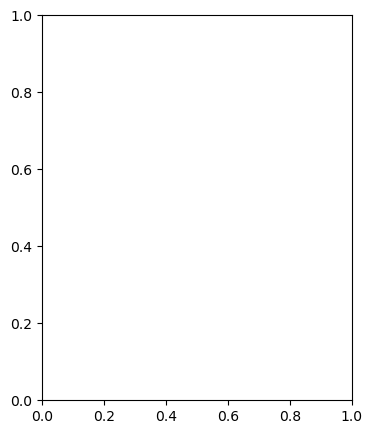

In [42]:
# Save the Pearson correlation scores
df = pd.DataFrame({"rbp_id": list(pearsonr_scores.keys()), "pearsonr": list(pearsonr_scores.values())})
df.to_csv(os.path.join(log_dir, "pearsonr_scores.csv"), index=False)

# Plot the Pearson correlation scores
data = [np.array(list(pearsonr_scores.values()))]
names = ['EUGENe ResidualBind']
boxplots(data, names, save=os.path.join(log_dir, "pearsonr_scores.png"))

# DONE!

---